In [18]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_pulsation, evaluate_pulsations
from spice.plots import plot_3D_mesh_and_spectrum
from spice.spectrum import simulate_observed_flux, GaussianLineEmulator
import astropy.units as u
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

from jax import config
# config.update('jax_platform_name', 'cpu')
config.update('jax_enable_x64', True)

In [19]:
ge = GaussianLineEmulator(
    line_centers=[5500.0],
    line_widths=[0.3],
    line_depths=[0.5]
)

wvs = jnp.log10(jnp.linspace(5498, 5502, 2000))

In [20]:
m = IcosphereModel.construct(1000, 1., 1.,
                             ge.to_parameters(), ge.parameter_names,
                             max_pulsation_mode=10)
m = add_pulsation(m, 2, 6, 1., jnp.array([[1e-2, 0.]]))

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:251: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
/Users/mjablons/anaconda3/envs/astro/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [21]:
TIMESTAMPS = jnp.linspace(0., 2., 20)
mps = [evaluate_pulsations(m, t) for t in tqdm(TIMESTAMPS)]

100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


In [22]:
spectra = [simulate_observed_flux(ge.intensity, mp, wvs) for mp in tqdm(mps)]

100%|██████████| 20/20 [00:00<00:00, 129.90it/s]


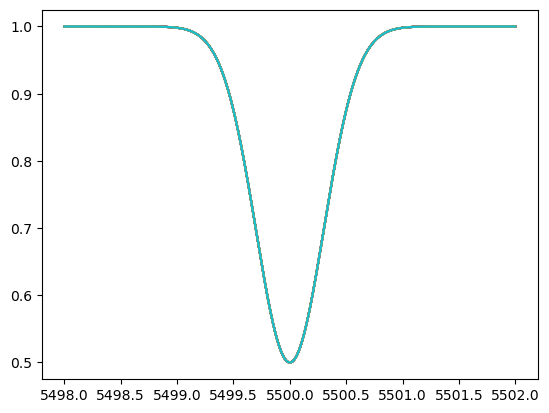

In [23]:
for s in spectra:
    plt.plot(10**wvs, s[:, 0]/s[:, 1])
plt.show()

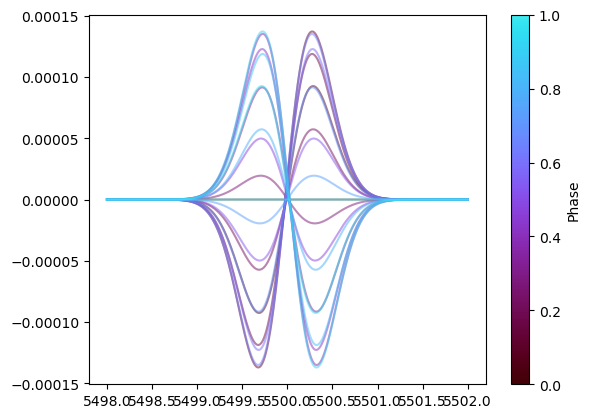

In [24]:
import cmasher as cmr
# Compute phases from timestamps (assuming period=1 for normalization)
phases = (TIMESTAMPS - TIMESTAMPS[0]) / (TIMESTAMPS[-1] - TIMESTAMPS[0])
norm = plt.Normalize(phases.min(), phases.max())
cmap = cmr.gem

fig, ax = plt.subplots()
for s, phase in zip(spectra, phases):
    ax.plot(10**wvs, (s[:, 0]/s[:, 1])-(spectra[0][:, 0]/spectra[0][:, 1]), color=cmap(norm(phase)), alpha=0.5)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(phases)
cbar = fig.colorbar(sm, ax=ax, label='Phase')
plt.show()